Our aim in this section will be to evaluate different assumptions about constraints on the relationship between syntactic and semantic types.

In [3]:
#| code-fold: true
#| code-summary: Define SelectionData

from dataclasses import dataclass
from numpy import ndarray

@dataclass
class SelectionData:
    verb: ndarray
    frame: ndarray
    subj: ndarray
    resp: ndarray

In [4]:
#| code-fold: true
#| code-summary: Define SelectionModelParameters
    
@dataclass
class SelectionModelParametersABC:
    n_verb: int
    n_frame: int
    n_subj: int
    n_resp_levels: int
    
@dataclass
class SelectionModelParameters(SelectionModelParametersABC):
    n_component: int

In [5]:
#| code-fold: true
#| code-summary: Define ordered_logistic_likelihood

import torch
from torch import Tensor

torch.set_default_tensor_type(torch.DoubleTensor)

def ordered_logistic_likelihood(value: Tensor, jumps: Tensor, center: bool = True) -> Tensor:
    """Compute the ordered logistic likelihood given a value
    
    Parameters
    ----------
    value
        The value to compute the likelihood for 
        (shape: batch_size)
    jumps
        The distance between cutpoints 
        (shape: batch_size x number of response levels - 1)

    Returns
    -------
    log_likelihood
        the ordered logistic log-likelihood
    """
    cutpoints = torch.cumsum(jumps, axis=1) 
    
    if center:
        cutpoints = cutpoints - cutpoints.mean(1)[:,None]
    
    cdfs = torch.sigmoid(cutpoints - value[:,None])

    low_prob = torch.cat(
        [torch.zeros([cdfs.shape[0], 1]), cdfs],
        axis=1
    )
    high_prob = torch.cat(
        [cdfs, torch.ones([cdfs.shape[0], 1])],
        axis=1
    )
    
    return high_prob - low_prob

In [6]:
#| code-fold: true
#| code-summary: Define SelectionModel

from typing import Optional
from torch import manual_seed
from torch import randn
from torch.nn import Module

ZERO = 1e-5
ONE = 1. - ZERO

class SelectionModel(Module):
    parameter_class = SelectionModelParameters
    data_class = SelectionData
    
    def __init__(self, parameters: SelectionModelParameters):
        super().__init__()
        
        self.model_parameters = parameters
        
        # prior parameters
        self.verb_component_prior_mean_aux = torch.nn.Parameter(
            randn(parameters.n_component), 
            requires_grad=True
        )
        self.frame_component_prior_mean_aux = torch.nn.Parameter(
            randn(parameters.n_component), 
            requires_grad=True
        )
        
        self.verb_component_prior_precision_aux = torch.nn.Parameter(
            randn(parameters.n_component), 
            requires_grad=True
        )
        self.frame_component_prior_precision_aux = torch.nn.Parameter(
            randn(parameters.n_component), 
            requires_grad=True
        )
        
        # latent matrices
        self.verb_component_aux = torch.nn.Parameter(
            randn([
                parameters.n_verb, parameters.n_component
            ]), 
            requires_grad=True
        )
        self.frame_component_aux = torch.nn.Parameter(
            randn([
                parameters.n_frame, parameters.n_component
            ]), 
            requires_grad=True
        )
        
        # likelihood parameters
        self.log_jumps = torch.nn.Parameter(
            torch.ones([
                parameters.n_subj, parameters.n_resp_levels-1
            ]), 
            requires_grad=True
        )

    def forward(self, data: SelectionData):
        # compute the verb frame probabilities
        verb_frame_prob = self.verb_frame_prob(
            data.verb, data.frame,
            clamp=True
        )
        
        # apply a logit to those probabilities
        verb_frame_logodds = torch.log(verb_frame_prob) -\
                             torch.log(1. - verb_frame_prob)
        
        # compute the jumps for each subject
        jumps = self.jumps[data.subj]
        
        # return the ordered logistic probabilities
        return ordered_logistic_likelihood(
            verb_frame_logodds, jumps
        )
    
    def verb_frame_prob(
        self, 
        verb_idx: Optional[ndarray] = None, 
        frame_idx: Optional[ndarray] = None,
        clamp: bool = False
    ) -> Tensor:
        if verb_idx is not None or frame_idx is not None:
            acc = 1. - torch.prod(
                1. - self.verb_component_prob[verb_idx,:] * 
                     self.frame_component_prob[frame_idx,:],
                axis=1
            ).clamp(ZERO, ONE)
        elif verb_idx is None and frame_idx is not None:
            acc = 1. - torch.prod(
                1. - self.verb_component_prob[:,None,:] * 
                     self.frame_component_prob[:,frame_idx,:],
                axis=2
            ).clamp(ZERO, ONE)
        elif verb_idx is not None and frame_idx is None:
            acc = 1. - torch.prod(
                1. - self.verb_component_prob[verb_idx,None,:] * 
                     self.frame_component_prob[None,:,:],
                axis=2
            ).clamp(ZERO, ONE)
        else:
            acc = 1. - torch.prod(
                1. - self.verb_component_prob[:,None,:] * 
                     self.frame_component_prob[None,:,:],
                axis=2
            )

        if clamp:
            return acc.clamp(ZERO, ONE)
        else:
            return acc
    
    @property
    def verb_component_prob(self) -> Tensor:
        return torch.sigmoid(self.verb_component_aux)
    
    @property
    def frame_component_prob(self) -> Tensor:
        return torch.sigmoid(self.frame_component_aux)
    
    @property
    def jumps(self):
        return torch.exp(self.log_jumps)
    
    @property
    def verb_component_prior_mean(self):
        return torch.sigmoid(self.verb_component_prior_mean_aux)
    
    @property
    def frame_component_prior_mean(self):
        return torch.sigmoid(self.frame_component_prior_mean_aux)
    
    @property
    def verb_component_prior_precision(self):
        return torch.exp(self.verb_component_prior_precision_aux)
    
    @property
    def frame_component_prior_precision(self):
        return torch.exp(self.frame_component_prior_precision_aux)

In [9]:
#| code-fold: true
#| code-summary: Define hash_series

from pandas import CategoricalDtype, Series, DataFrame

def hash_series(series: Series, categories: Optional[list[str]] = None, indexation: int=1) -> tuple[ndarray, ndarray]:
    """Hash a series to numeric codes
    
    Parameters
    ----------
    column
        The series to hash
    index
        The starting index (defaults to 1)
    """
    # enforce 0- or 1-indexation
    if indexation not in [0, 1]:
        raise ValueError("Must choose either 0- or 1-indexation.")
    
    # convert the series to a category
    if categories is None:
        category_series = series.astype("category")
    else:
        cat_type = CategoricalDtype(categories=categories)
        category_series = series.astype(cat_type)
    
    # get the hash
    hash_map = category_series.cat.categories.values
    
    # map to one-indexed codes
    hashed_series = (category_series.cat.codes + indexation).values
    
    return hash_map, hashed_series

## Implementing trainers in `torch`

As mentioned in the last section, we'll estimate the parameters contained in our `SelectionModel`, `StructuredSelectionModel`, and `ConstrainedStructuredSelectionModel` `Module`s using a *trainer class*. This class will do a few things for us.

First, it will format the model hyperparameters and data for consumption by the `Module`. Across all of our models, the format of the data (`SelectionData`) will remain the same, though the shape of the objects containing the hyperparameters will differ. 

Second, It will compute the (unnormalized) posterior given the current setting of the model parameters contained in the `Module`. The posterior is unnormalized in the sense that we won't bother with computing the evidence, since the evidence is not relevant for computing $\arg_{\boldsymbol\theta}\max p(\boldsymbol\theta \mid \mathbf{x})$, since the evidence $p(\mathbf{x})$ is a constant relative to $\boldsymbol\theta$:

$$\arg_{\boldsymbol\theta}\max p(\boldsymbol\theta \mid \mathbf{x}) = \arg_{\boldsymbol\theta}\max \frac{p(\mathbf{x} \mid \boldsymbol\theta)p(\boldsymbol\theta)}{p(\mathbf{x})} = \arg_{\boldsymbol\theta}\max p(\mathbf{x} \mid \boldsymbol\theta)p(\boldsymbol\theta)$$

Finally and most importantly, it will actually conduct gradient descent by computing the gradient $\nabla p(\boldsymbol\theta \mid \mathbf{x})$ and then taking a step in the direction of the gradient.

All of the trainrs for our `Module`s will use an abstract base class `SelectionModelTrainerABC`. Similar to our wrappers for `CmdStanModel`s from Modules 1 and 2, the trainers will (partially) conform to the `sklearn` API by implementing a fit method that returns the trainer itself.

In [10]:
from abc import ABC, abstractmethod
from numpy import arange, round, sum, abs, mean, inf, random, corrcoef, concatenate

class SelectionModelTrainerABC(ABC):
    data_class = SelectionData
    
    @abstractmethod
    def construct_model_parameters(self, data: DataFrame) -> SelectionModelParameters:
        raise NotImplementedError
        
    def construct_model_data(self, data: DataFrame) -> SelectionData:            
        frame_hashed, verb_hashed, subj_hashed = self._construct_hashes(data)
        
        model_data = {
            "verb": verb_hashed,
            "frame": frame_hashed,
            "subj": subj_hashed,
            "resp": data.response.astype(int).values - 1
        }
        
        return self.data_class(**model_data)
    
    def _construct_hashes(self, data: DataFrame):
        if hasattr(self, "frame_hash_map"):
            _, frame_hashed = hash_series(data.frame, self.frame_hash_map, indexation=0)
        else:
            self.frame_hash_map, frame_hashed = hash_series(data.frame, indexation=0)
            
        if hasattr(self, "verb_hash_map"):
            _, verb_hashed = hash_series(data.verb, self.verb_hash_map, indexation=0)
        else:
            self.verb_hash_map, verb_hashed = hash_series(data.verb, indexation=0)

        if hasattr(self, "subj_hash_map"):
            _, subj_hashed = hash_series(data.participant, self.subj_hash_map, indexation=0)
        else:
            self.subj_hash_map, subj_hashed = hash_series(data.participant, indexation=0)
            
        return frame_hashed, verb_hashed, subj_hashed
    
    def _initialize_model(self, data: DataFrame):
        model_parameters = self.construct_model_parameters(data)
        
        return self.model_class(model_parameters)
    
    def _construct_splits(self, data: DataFrame) -> tuple[DataFrame]:
        verbs = data.verb.unique()
        frames = data.frame.unique()
        
        verb_frame_pairs = [v + "_" + f for v in verbs for f in frames]
        
        n_dev = int(len(verb_frame_pairs) / 10)
        
        verb_frame_pairs_dev = random.choice(verb_frame_pairs, n_dev, replace=False)
        
        dev_indicator = (data.verb + "_" + data.frame).isin(verb_frame_pairs_dev)
        
        data_train = data[~dev_indicator]
        data_dev = data[dev_indicator]
        
        return data_train, data_dev
    
    def fit(
        self, data: DataFrame, batch_size=1_000, max_epochs:int=10_000, 
        lr: float = 1e-5, patience: int = 100, 
        tolerance_loss: float = 1e-5, tolerance_heldout: float = 0.05, 
        window_size: int = 100, verbosity: int=100, seed: int = 403928
    ) -> SelectionModelTrainerABC:
        manual_seed(seed)
        random.seed(seed)
        
        # necessary for initializing hashes that contain all verbs, frames,
        # and subjects
        self._construct_hashes(data)
        data_train, data_dev = self._construct_splits(data)
        self.model = self._initialize_model(data_train)
        
        # wrap the dev split responses in a tensor
        # this tensor will be used to compute the correlation between
        # the models expected value for a response and the actual
        # response
        target_dev = torch.tensor(data_dev.response.values)
        
        # initialize the optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        
        # initialize the loss trace
        self.loss_trace = [inf]
        
        # initialize the dev-train correlations trace
        self.corr_train_trace = []
        self.corr_dev_trace = []
        
        # initialize the loss differences trace
        loss_diffs_trace = []
        
        # initialize the dev-train correlation differences trace
        corr_diffs_trace = []
        
        for e in range(max_epochs):
            # shuffle the training data
            data_shuffled = data_train.sample(frac=1.)
            data_shuffled = data_shuffled.reset_index(drop=True)
            
            # compute the number of batches based on the batch size
            n_batches = int(data_shuffled.shape[0]/batch_size)
        
            # zero the total loss for the epoch
            epoch_total_loss = 0.
        
            # initialize the list of correlations
            correlations_train = []
            
            for i in range(n_batches):
                # construct the minibatch
                lower_bound = i*batch_size
                
                if i == (n_batches - 1):
                    upper_bound = data_shuffled.shape[0]
                else:
                    upper_bound = (i+1)*batch_size

                data_sub = self.construct_model_data(
                    data_shuffled.iloc[lower_bound:upper_bound]
                )
                
                # wrap the responses in a tensor
                target = torch.tensor(data_sub.resp)

                # zero out the gradients
                optimizer.zero_grad()

                # compute the (log-)probabilities for the minibatch
                probs = self.model(data_sub)
                logprobs = torch.log(probs)

                # compute the loss
                loss = self.loss_function(logprobs, target)
                loss += self._prior_loss()
                
                # compute gradients
                loss.backward()

                # take a step in the direction of the gradient
                optimizer.step()
                
                # compute correlation between expected value and target
                expected_value_train = sum(
                    arange(1, probs.shape[1]+1)[None,:] *
                    probs.detach().numpy(), 
                    axis=1
                )
                corr_train = corrcoef(
                    concatenate([
                        expected_value_train[None,:], 
                        data_sub.resp[None,:]
                    ], axis=0)
                )
                correlations_train.append(
                    corr_train[0,1]
                )
                
                # compute total loss
                epoch_total_loss += loss.detach().numpy()
            
            # compute the difference between the current and previous loss
            loss_diff = self.loss_trace[-1] - epoch_total_loss
            loss_diff_scaled = loss_diff/abs(self.loss_trace[-1]) if e else inf
            loss_diffs_trace.append(
                loss_diff_scaled
            )
            
            # save epoch mean loss
            self.loss_trace.append(epoch_total_loss)
            
            # compute correlation between exp. value and ratings
            # in the dev set
            expected_value_dev = self.expected_value(data_dev)
            corr_dev = corrcoef(
                concatenate([
                    expected_value_dev[None,:], 
                    data_dev.response.values[None,:]
                ], axis=0)
            )[0,1]
            self.corr_dev_trace.append(
                corr_dev
            )
            
            # compute and save the mean correlation in the train set
            correlations_train_mean = mean(correlations_train)
            self.corr_train_trace.append(correlations_train_mean)
            
            # compute the difference between the mean train correlation
            # and the dev correlation
            corr_diffs_trace.append(
                correlations_train_mean - corr_dev
            )
            
            if verbosity and not e % verbosity:
                print(f"Epoch:             {e}")
                print(f"Loss:              {round(epoch_total_loss)}")
                print(f"loss improvement:  {round(loss_diff_scaled, 7)}")
                print(f"Mean train corr.:  {round(correlations_train_mean, 2)}")
                print(f"Dev corr.:         {round(corr_dev, 2)}")
                print()
          
            max_window_size = min(len(corr_diffs_trace), window_size)
            mean_diff = torch.mean(
                torch.tensor(corr_diffs_trace[-max_window_size:])
            )
            
            if e > patience and (mean_diff > tolerance_heldout or loss_diff_scaled < tolerance_loss):
                
                if verbosity:
                    print(f"Epoch:             {e}")
                    print(f"Loss:              {round(epoch_total_loss)}")
                    print(f"loss improvement:  {round(loss_diff_scaled, 7)}")
                    print(f"Mean train corr.:  {round(correlations_train_mean, 2)}")
                    print(f"Dev corr.:         {round(corr_dev, 2)}")
                    print()
                
                break
            else:
                prev_corr_dev = corr_dev
        
        return self
    
    @abstractmethod
    def _prior_loss(self):
        raise NotImplementedError
    
    def expected_value(self, data: DataFrame):
        model_data = self.construct_model_data(data)
        probs = self.model(model_data).detach().numpy()
        
        expected_value = sum(
            arange(1, 8)[None,:] * probs, 
            axis=1
        )
        
        return expected_value
    
    def likelihood(self, data: DataFrame):
        model_data = self.construct_model_data(data)
        probs = self.model(model_data)
        
        return probs[model_data.resp]
    
    def predict(self, data: DataFrame):
        model_data = self.construct_model_data(data)
        probs = self.model(model_data)
        
        return probs[model_data.resp]

## Fitting the `SelectionModel`

To implement a trainer (`SelectionModelTrainer`) for our basic `SelectionModel`, we need to specify three things: (i) how to initialize the `SelectionModelTrainer`; (ii) how to construct the model parameters; and (iii) how to compute the prior.

In [11]:
from torch.distributions.gamma import Gamma
from torch.distributions.exponential import Exponential

class SelectionModelTrainer(SelectionModelTrainerABC):
    parameter_class = SelectionModelParameters
    model_class = SelectionModel
    
    def __init__(self, n_component: int):
        self.n_component = n_component
        
        self.loss_function = torch.nn.CrossEntropyLoss(reduction="sum")
    
    def construct_model_parameters(self, data: DataFrame) -> SelectionModelParametersABC:
        model_parameters = {
            "n_verb": self.verb_hash_map.shape[0],
            "n_frame": self.frame_hash_map.shape[0],
            "n_subj": self.subj_hash_map.shape[0],
            "n_resp_levels": 7,
            "n_component": self.n_component,
        }
        
        return self.parameter_class(**model_parameters)
    
    def _prior_loss(self):
        jumps = self.model.jumps
        loss = (jumps / jumps.mean(0)[None,:]).mean()
        
        return loss

In [12]:
#| code-fold: true
#| code-summary: Load the data

import os
from pandas import read_csv

def load_data(fname: str, verbose: bool = True) -> DataFrame:
    # read the raw data skipping comment rows at the beginning
    data = read_csv(fname, sep="\t")
    
    if verbose:
        n_datapoints = data.shape[0]
        print(f"The full dataset has {n_datapoints} datapoints.")
    
    # remove non-native speakers
    if "nativeenglish" in data.columns:
        data = data.query("nativeenglish")
    
    if verbose:
        n_datapoints_native = data.shape[0]
        print(f"Removing {n_datapoints - n_datapoints_native} "
              "responses from nonnative speakers.")
    
    # remove NaN judgments
    data = data.query("~response.isnull()")
    
    if verbose:
        n_datapoints_nonnull = data.shape[0]
        print(f"Removing {n_datapoints_native - n_datapoints_nonnull} NA responses.")
    
    return data

data_dir = "./data/mega-acceptability-v1/"
data = load_data(os.path.join(data_dir, "mega-acceptability-v1.tsv"))

The full dataset has 250000 datapoints.
Removing 600 responses from nonnative speakers.
Removing 10 NA responses.


In [ ]:
selection_model = SelectionModelTrainer(39)
selection_model.fit(data)

To get a sense for how well this model fits the data, we can compare the expected response it assigns to each datapoint to the actual response.

SignificanceResult(statistic=0.5189593508120506, pvalue=0.0)

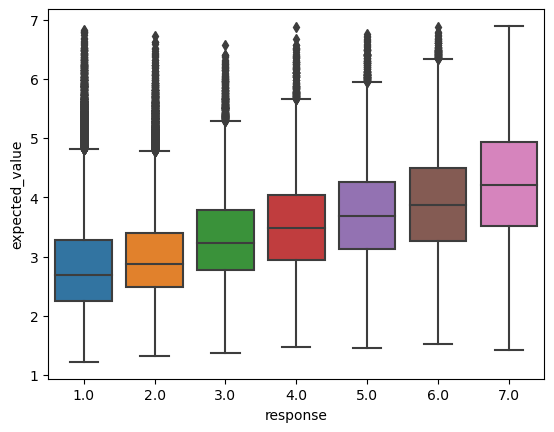

In [72]:
#| code-fold: true
#| code-summary: Plotting code

from scipy.stats import spearmanr
from seaborn import boxplot

data["expected_value"] = selection_model.expected_value(data).data

_ = boxplot(data, x="response", y="expected_value")

spearmanr(data[["response", "expected_value"]])

We see these expected values have a correlation relatively near the level that @white_frequency_2020 report that participants agree with each other (mean Spearman $\rho=0.55$).

In [36]:
frame_component_prob = DataFrame(
    selection_model.model.frame_component_prob.data,
    index=selection_model.frame_hash_map
)

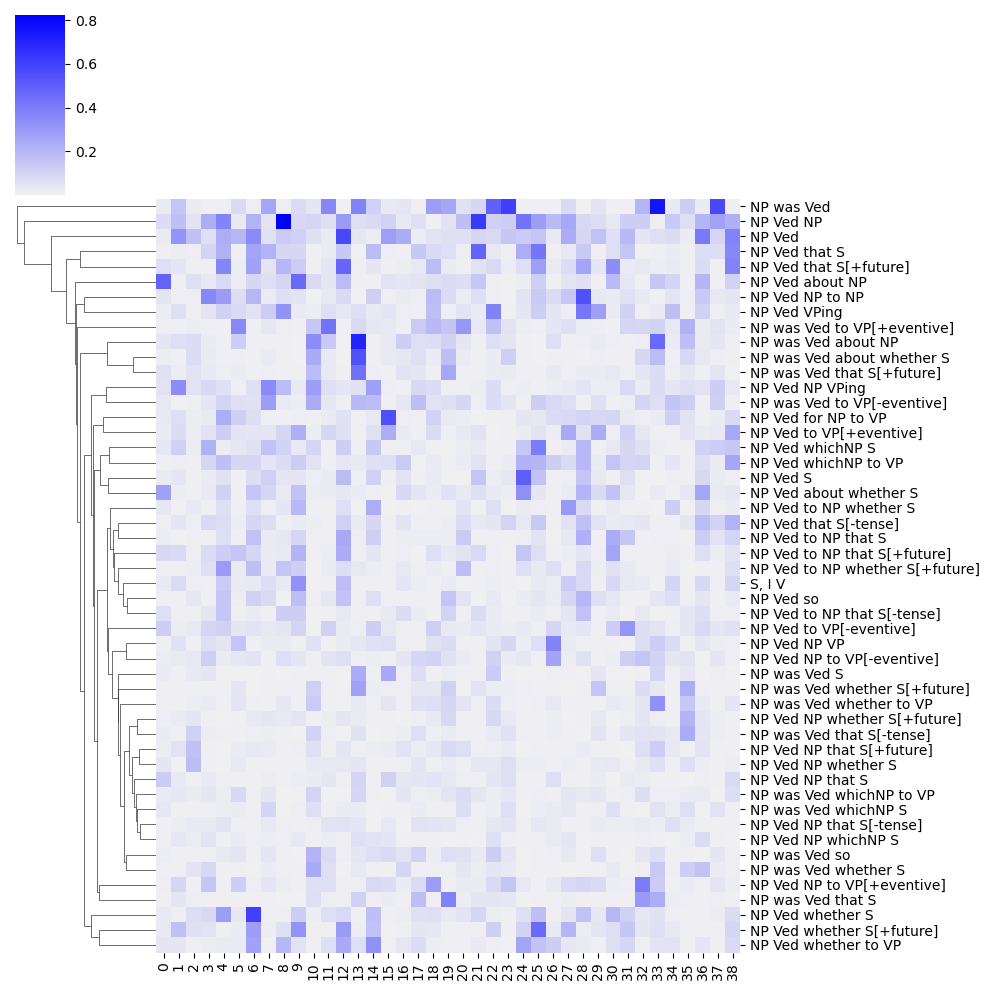

In [14]:
#| code-fold: true
#| code-summary: Plotting code

from seaborn import clustermap, color_palette

clustermap(
    frame_component_prob, 
    cmap=color_palette("light:b", as_cmap=True), 
    yticklabels=True, 
    col_cluster=False
)

In [35]:
verb_component_prob = DataFrame(
    selection_model.model.verb_component_prob.data,
    index=selection_model.verb_hash_map
)

/opt/conda/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


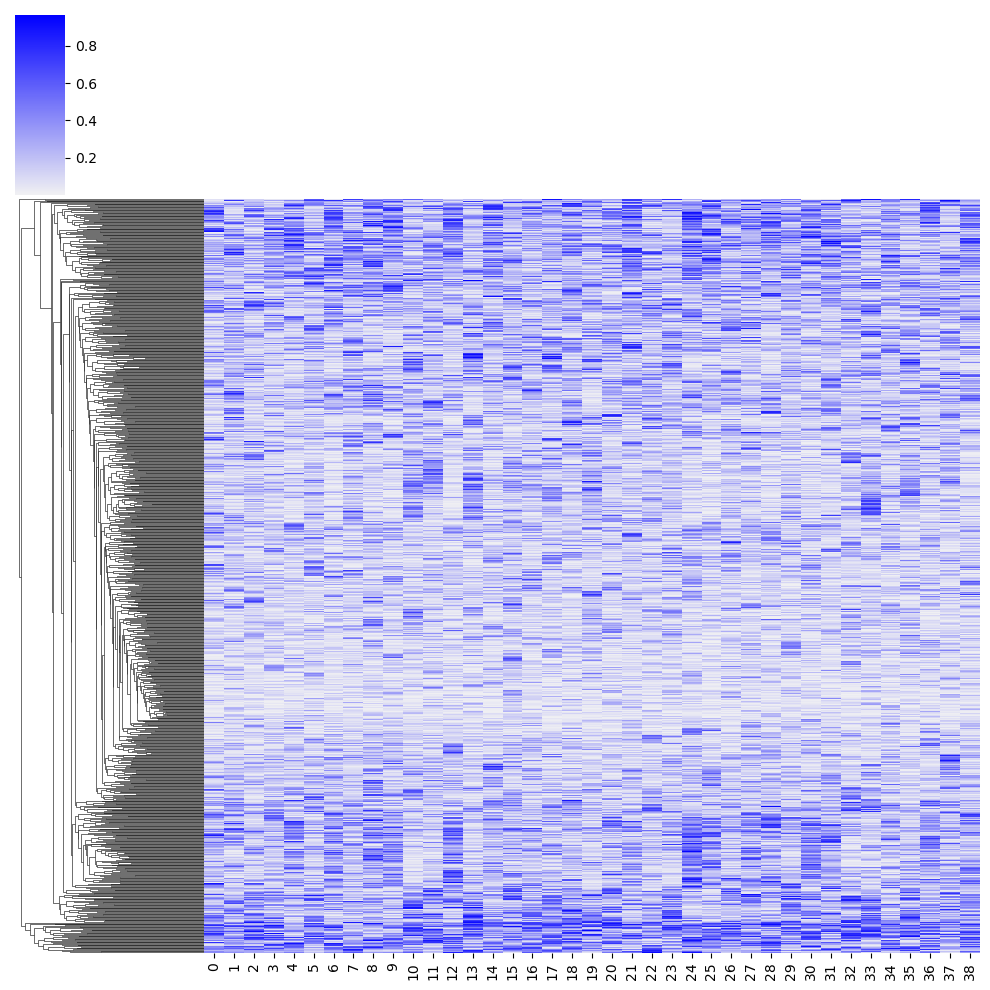

In [17]:
#| code-fold: true
#| code-summary: Plotting code

_ = clustermap(
    verb_component_prob, 
    cmap=color_palette("light:b", as_cmap=True), 
    yticklabels=False,
    col_cluster=False,
)

To evaluate this model's ability to capture temporal orientation, we'll ask how well we can predict the judgments in MegaOrientation using the probabilities contained in $\boldsymbol\Lambda$ and $\boldsymbol\Pi$ as predictors in a mixed effects model. We'll use the implementation we developed in Module 1.

In [69]:
#| code-fold: true
#| code-summary: Define MixedEffectsModel

import patsy
from numpy import array
from cmdstanpy import CmdStanModel
from arviz import InferenceData

@dataclass
class MixedEffectsData:
    N_resp: int                  # number of responses
    N_subj: int                  # number of subjects
    N_resp_levels: int           # number of possible likert scale acceptability judgment responses
    subj: ndarray                # subject who gave response n
    resp: ndarray                # likert scale acceptability judgment responses
    N_fixed: int                 # number of fixed predictors
    fixed_predictors: ndarray    # predictors (length and dependency type) including intercept
    N_item: int                  # number of items
    N_by_item: int               # number of random by-item predictors
    by_item_predictors: ndarray  # by-item predictors (length and dependency type) including intercept
    N_by_subj: int               # number of random by-subject predictors
    by_subj_predictors: ndarray  # by-subject predictors (length and dependency type) including intercept
    item: ndarray                # item corresponding to response n

class MixedEffectsModel:
    stan_file = "../island-effects/models/mixed-effects-model/mixed-effects-model.stan"
    data_class = MixedEffectsData
    
    def __init__(
        self, fixed_formula: str, by_subj_formula: str, by_item_formula: str, 
    ):
        self.model = CmdStanModel(stan_file=self.stan_file)
        
        self.fixed_formula = fixed_formula
        self.by_subj_formula = by_subj_formula
        self.by_item_formula = by_item_formula
    
    def _validate_data(self):
        self.data_class(**self.model_data)
    
    def construct_model_data(self, data: DataFrame):
        self.fixed_predictors = patsy.dmatrix(
            self.fixed_formula, data, return_type="dataframe"
        )
        
        self.by_subj_predictors = patsy.dmatrix(
            self.by_subj_formula, data, return_type="dataframe"
        )
        
        self.by_item_predictors = patsy.dmatrix(
            self.by_item_formula, data, return_type="dataframe"
        )
        
        self.subj_hash_map, subj_hashed = hash_series(data.participant)
        self.item_hash_map, item_hashed = hash_series(data.sentence)
        
        model_data = {
            "N_resp": data.shape[0],
            "N_subj": self.subj_hash_map.shape[0],
            "N_resp_levels": 7,
            "subj": subj_hashed,
            "resp": data.response.astype(int).values,
            "N_fixed": self.fixed_predictors.shape[1],
            "fixed_predictors": self.fixed_predictors.values,
            "N_by_subj": self.by_subj_predictors.shape[1],
            "by_subj_predictors": self.by_subj_predictors.values,
            "N_item": self.item_hash_map.shape[0],
            "N_by_item": self.by_item_predictors.shape[1],
            "by_item_predictors": self.by_item_predictors.values,
            "item": item_hashed
        }
        
        return model_data

    def fit(
        self, 
        data: DataFrame,
        save_dir: Optional[str] = None,
        verbose: bool = False,
        map_initialization: bool = True,
        seed: int = 50493,
        **kwargs
    ) -> InferenceData:
        if verbose:
            print("Constructing model data...")
            
        self.model_data = self.construct_model_data(data)
        
        self._validate_data()
        
        if map_initialization:
            if verbose:
                print("Fitting model with MAP initialization...")

            map_estimate = self._compute_map_estimate(seed)
            
            if "inits" in kwargs:
                # inits passed to fit() should override MAP
                map_estimate.update(kwargs["inits"])

            kwargs["inits"] = map_estimate
        
        elif verbose:
            print("Fitting model...")
        
        # sample from the posterior starting at the MAP
        self.raw_model_fit = self.model.sample(
            data=self.model_data,
            **kwargs
        )
    
        if save_dir is not None:
            if verbose:
                print("Saving model...")

            self.save(save_dir)
            
        if verbose:
            print("Running MCMC diagnostics...")
            print()
            print(self.diagnose())
    
        return self
    
    def _compute_map_estimate(self, seed:int):
        # compute MAP fit
        self.map_model_fit = self.model.optimize(
            data=self.model_data,
            seed=seed,
            algorithm="lbfgs",
            tol_obj=1.
        )
        
        map_estimate = self.map_model_fit.stan_variables()
        
        for vname, v in map_estimate.items():
            if "cov" in vname and not hasattr(v, "shape"):
                map_estimate[vname] = array([[v]])
                
        return map_estimate
    
    @property
    def model_fit(self):
        return arviz.from_cmdstanpy(self.raw_model_fit)
    
    def save(self, save_dir: str = "."):
        self.raw_model_fit.save_csvfiles(save_dir)
    
    @classmethod
    def from_csv(cls, path: str, **kwargs):
        model = cls(**kwargs)
        model.raw_model_fit = cmdstanpy.from_csv(path)
        
    def diagnose(self):
        return self.raw_model_fit.diagnose()

In [70]:
#| code-fold: true
#| code-summary: Load MegaOrientation data

data_dir = "./data/mega-orientation-v1.1/"

data_orientation = load_data(os.path.join(data_dir, "mega-orientation-v1.1.tsv"))

data_orientation["frame"] = data_orientation.frame.str.replace("_", "V")

The full dataset has 44160 datapoints.
Removing 0 responses from nonnative speakers.
Removing 0 NA responses.


In [ ]:
from pandas import merge

data_orientation_with_comps = merge(
    merge(
        data_orientation, 
        verb_component_prob.rename(columns=lambda x: f"verbcomp{x}"), 
        left_on="verb", right_index=True
    ),
    frame_component_prob.rename(columns=lambda x: f"framecomp{x}"),
    left_on="frame", right_index=True
)

frame_comp_form = " + ".join(frame_component_prob.columns.map(lambda x: f"framecomp{x}"))
verb_comp_form = " + ".join(verb_component_prob.columns.map(lambda x: f"verbcomp{x}"))

selection_model_validation = MixedEffectsModel(
    fixed_formula=f"~ ({verb_comp_form} + {frame_comp_form}) * orientation",
    by_subj_formula=f"~ 1",
    by_item_formula="~ 1",
)

selection_model_validation.fit(data_orientation_with_comps)

## Fitting the `StructuredSelectionModel`

In [ ]:
#| code-fold: true
#| code-summary: Frame-to-constitutent mapping

from collections import OrderedDict

frame_to_constituents = OrderedDict({
    'NP was Ved whichNP to VP': {
        ("NP_subj", "NP_obj", "whichNP to VP"),
        ("NP_obj", "whichNP to VP")
    }, 
    'NP Ved for NP to VP': {
        ("NP_subj", "for NP to VP"), 
        ("NP_subj", "PP_for", "to VP")
    },
    'NP Ved NP to VP[+eventive]': {
        ("NP_subj", "NP to VP[+eventive]"), 
        ("NP_subj", "NP_obj", "to VP[+eventive]")
    }, 
    'NP was Ved whether to VP': {
        ("NP_subj", "NP_obj", "whether to VP"),
        ("NP_obj", "whether to VP")
    },
    'NP Ved to VP[+eventive]': {
        ("NP_subj", "to VP[+eventive]")
    }, 
    'NP Ved NP to NP': {
        ("NP_subj", "NP_obj", "NP_iobj") 
    }, 
    'NP Ved NP that S': {
        ("NP_subj", "NP_obj", "that S") 
    },
    'NP was Ved about NP': {
        ("NP_subj", "NP_obj", "about NP") ,
        ("NP_obj", "about NP") 
    }, 
    'NP was Ved that S[-tense]': {
        ("NP_subj", "NP_obj", "S[-tense]") ,
        ("NP_obj", "S[-tense]") 
    },
    'NP Ved to NP that S[+future]': {
        ("NP_subj", "NP_iobj", "that S[+future]") 
    }, 
    'NP Ved whether to VP': {
        ("NP_subj", "whether to VP")
    },
    'NP Ved whichNP to VP': {
        ("NP_subj", "whichNP to VP")
    }, 
    'NP Ved about whether S': {
        ("NP_subj", "about whether S") 
    },
    'NP Ved whichNP S': {
        ("NP_subj", "whichNP S")
    }, 
    'NP Ved that S[-tense]': {
        ("NP_subj", "that S[-tense]") 
    },
    'NP Ved whether S[+future]': {
        ("NP_subj", "whether S[+future]") 
    }, 
    'NP was Ved that S[+future]': {
        ("NP_subj", "NP_obj", "that S[+future]") ,
        ("NP_obj", "that S[+future]") 
    },
    'NP Ved to NP whether S': {
        ("NP_subj", "NP_iobj", "whether S") 
    }, 
    'NP Ved': {
        ("NP_subj",)
    }, 
    'NP Ved NP to VP[-eventive]': {
        ("NP_subj", "NP to VP[-eventive]"), 
        ("NP_subj", "NP_obj", "to VP[-eventive]"),
        ("NP_subj", "NP to VP[-eventive]")
    },
    'NP was Ved so': {
        ("NP_obj", "so"), 
        ("NP_subj", "NP_obj", "so")
    }, 
    'NP Ved so': {
        ("NP_subj", "so")
    }, 
    'NP Ved NP that S[+future]': {
        ("NP_subj", "NP_obj", "that S[+future]")
    },
    'NP Ved NP whether S[+future]': {
        ("NP_subj", "NP_obj", "whether S[+future]")
    }, 
    'NP Ved to NP whether S[+future]': {
        ("NP_subj", "NP_iobj", "whether S[+future]")
    },
    'NP was Ved that S': {
        ("NP_obj", "that S"), 
        ("NP_subj", "NP_obj", "that S")
    }, 
    'NP Ved NP whether S': {
        ("NP_subj", "NP_obj", "whether S")
    }, 
    'NP was Ved whether S': {
        ("NP_obj", "whether S"), 
        ("NP_subj", "NP_obj", "whether S")
    },
    'NP was Ved to VP[-eventive]': {
        ("NP_obj", "to VP[-eventive]"), 
        ("NP_subj", "NP_obj", "to VP[-eventive]"),
        ("NP_subj", "NP to VP[-eventive]")
    }, 
    'NP Ved NP VP': {
        ("NP_subj", "NP_obj", "VP"),
        ("NP_subj", "NP VP")
    }, 
    'NP Ved VPing': {
        ("NP_subj", "VPing")
    },
    'NP was Ved to VP[+eventive]': {
        ("NP_obj", "to VP[+eventive]"), 
        ("NP_subj", "NP_obj", "to VP[+eventive]"),
        ("NP_subj", "NP to VP[+eventive]")
    }, 
    'NP Ved NP that S[-tense]': {
        ("NP_subj", "NP_obj", "that S[-tense]")
    },
    'NP Ved that S': {
        ("NP_subj", "that S")
    }, 
    'NP was Ved': {
        ("NP_obj",), 
        ("NP_subj", "NP_obj")
    }, 
    'NP Ved S': {
        ("NP_subj", "S")
    },
    'NP Ved that S[+future]': {
        ("NP_subj", "that S[+future]")
    }, 
    'NP was Ved about whether S': {
        ("NP_subj", "NP_obj", "about whether S") ,
        ("NP_obj", "about whether S") 
    },
    'NP Ved NP': {
        ("NP_subj", "NP_obj") 
    }, 
    'NP Ved NP VPing': {
        ("NP_subj", "NP_obj", "VPing"),
        ("NP_subj", "NP VPing")
    }, 
    'NP Ved NP whichNP S': {
        ("NP_subj", "NP_obj", "whichNP S")
    },
    'NP Ved about NP': {
        ("NP_subj", "about NP") 
    }, 
    'NP was Ved S': {
        ("NP_subj", "NP_obj", "S") ,
        ("NP_obj", "S") 
    }, 
    'NP Ved to NP that S': {
        ("NP_subj", "NP_iobj", "that S"),
    },
    'NP was Ved whether S[+future]': {
        ("NP_subj", "NP_obj", "whether S[+future]") ,
        ("NP_obj", "whether S[+future]") 
    }, 
    'NP Ved whether S': {
        ("NP_subj", "whether S") 
    },
    'NP was Ved whichNP S': {
        ("NP_subj", "NP_obj", "whichNP S") ,
        ("NP_obj", "whichNP S") 
    }, 
    'NP Ved to NP that S[-tense]': {
        ("NP_subj", "NP_iobj", "that S[-tense]")
    },
    'NP Ved to VP[-eventive]': {
        ("NP_subj", "to VP[-eventive]")
    }
})

data = data[data.frame.isin(frame_to_constituents)]

In [ ]:
#| code-fold: true
#| code-summary: Constituent-to-feature vector mapping

from numpy import array, zeros, where, isin
from xarray import DataArray

constituents = array(sorted({
    c 
    for tups in frame_to_constituents.values() 
    for t in tups 
    for c in t
}))

max_parses = max(
    len(t) 
    for tups in frame_to_constituents.values() 
    for t in tups 
)
    
frame_to_parse_constituent_indicators = zeros([
    len(frame_to_constituents), max_parses, len(constituents)
])
    
for i, (f, parses) in enumerate(frame_to_constituents.items()):
    for j, parse in enumerate(parses):
        for k, const in enumerate(parse):
            const_idx = where(constituents == const)[0][0]
            frame_to_parse_constituent_indicators[i,j,const_idx] = 1.
            
frame_to_parse_constituent_indicators = DataArray(
    frame_to_parse_constituent_indicators, 
    dims=["frame", "parse", "constituent"],
    coords={
        "frame": list(frame_to_constituents),
        "parse": list(range(max_parses)),
        "constituent": constituents,
    }
)

In [ ]:
#| code-fold: true
#| code-summary: Define StructuredSelectionModel

from numpy import prod
from torch import tensor

@dataclass
class StructuredSelectionModelParameters(SelectionModelParametersABC):
    frame_to_parse_constituent_indicators: ndarray
    n_primitive_semantic_types: int
    n_primitive_syntactic_types: int
    max_complex_type_size: int

class StructuredSelectionModel(Module):
    parameter_class = StructuredSelectionModelParameters
    data_class = SelectionData
    
    def __init__(self, parameters: StructuredSelectionModelParameters):
        super().__init__()
        
        self.model_parameters = parameters
        
        # initialize the verb-complex semantic type probabilities
        self._initialize_verb_complex_semantic_type()
        
        # initialize the frame-complex syntactic type probabilities
        self._initialize_frame_complex_syntactic_type()
        
        # initialize the semantic-syntactic primitive type map
        self._initialize_primitive_type_map()
        
        # initialize the syntactic primitive type-constituent map
        syntactic_primitive_type_constituent_map_aux = torch.zeros([
             parameters.n_primitive_syntactic_types,
             parameters.frame_to_parse_constituent_indicators.shape[2]
        ])
        self.syntactic_primitive_type_constituent_map_aux = torch.nn.Parameter(
            syntactic_primitive_type_constituent_map_aux, 
            requires_grad=True
        )
        
        # initialize the cutpoint distances
        self.log_jumps = torch.nn.Parameter(
            torch.ones([
                parameters.n_subj, parameters.n_resp_levels-1
            ]), 
            requires_grad=True
        )

    def _initialize_verb_complex_semantic_type(self):
        verb_shape = (self.model_parameters.n_verb,) +\
                     self.complex_semantic_type_shape
        self.verb_complex_semantic_type_aux = torch.nn.Parameter(
            torch.randn(verb_shape), 
            requires_grad=True
        )
        
    def _initialize_frame_complex_syntactic_type(self):
        frame_shape = (self.model_parameters.n_frame,) +\
                      self.complex_syntactic_type_shape
        self.frame_complex_syntactic_type_aux = torch.nn.Parameter(
            torch.randn(frame_shape), 
            requires_grad=True
        )
        
    def _initialize_primitive_type_map(self):
        primitive_type_map_aux = randn([
            self.model_parameters.n_primitive_semantic_types, 
            self.model_parameters.n_primitive_syntactic_types + 1
        ])
        self.primitive_type_map_aux = torch.nn.Parameter(
            primitive_type_map_aux, 
            requires_grad=True
        )
        
    @property
    def complex_semantic_type_shape(self):
        return (self.model_parameters.n_primitive_semantic_types+1,) *\
               self.model_parameters.max_complex_type_size
    
    @property
    def complex_syntactic_type_shape(self):
        return (self.model_parameters.n_primitive_syntactic_types+1,)*\
               self.model_parameters.max_complex_type_size
        
    def forward(self, data: SelectionData):
        verb_frame_prob = self.verb_frame_prob(data.verb, data.frame)
        verb_frame_logodds = torch.log(verb_frame_prob) - torch.log(1. - verb_frame_prob)
        
        jumps = self.jumps[data.subj]
        
        return ordered_logistic_likelihood(
            verb_frame_logodds, jumps
        )
    
    def verb_frame_prob(self, verb_idx: ndarray, frame_idx: ndarray) -> Tensor:
        n_verb = self.model_parameters.n_verb
        n_frame = self.model_parameters.n_frame
        
        verb_shape = self.complex_semantic_type_shape +\
                     (1,) * len(self.complex_syntactic_type_shape)
        frame_shape = (1,) * len(self.complex_semantic_type_shape) +\
                      self.complex_syntactic_type_shape
            
        if verb_idx.shape != frame_idx.shape:
            raise ValueError
        else:
            resp_shape = verb_idx.shape[0]
            
        # shape for verbs and frames to complex type signatures
        verb_shape = (resp_shape,) + verb_shape
        frame_shape = (resp_shape,) + frame_shape

        # shape with response dimension inserted into map
        synsem_map_shape = (1,) +\
                           self.complex_semantic_type_shape +\
                           self.complex_syntactic_type_shape
        
        # shape for broadcasting syn map
        syn_map_shape = (resp_shape,) +\
                        (1,) * self.model_parameters.max_complex_type_size +\
                        self.complex_syntactic_type_shape

        # shape for computing prod on all but the reponse dimension
        flat_shape = (resp_shape, prod(synsem_map_shape))
        
        p = self.verb_complex_semantic_type[verb_idx].view(verb_shape) *\
            self.frame_complex_syntactic_type[frame_idx].view(frame_shape) *\
            self.complex_synsem_type_map.view(synsem_map_shape) *\
            self.complex_syn_type_map[frame_idx].view(syn_map_shape)

        acc = 1. - (1. - p.view(flat_shape)).prod(axis=1)
        acc = acc.clamp(min=ZERO, max=ONE)

        return acc
            
    
    @property
    def verb_complex_semantic_type(self) -> Tensor:
        return torch.sigmoid(self.verb_complex_semantic_type_aux)
    
    @property
    def frame_complex_syntactic_type(self) -> Tensor:
        return torch.sigmoid(self.frame_complex_syntactic_type_aux)
    
    @property
    def primitive_type_map(self) -> Tensor:
        prob = torch.sigmoid(
            self.primitive_type_map_aux
        )
        
        # the 0th primitive type is the null primitive type and null 
        # primitive types should only map onto each other
        null_map = torch.zeros([
            1,
            self.model_parameters.n_primitive_syntactic_types + 1,
        ])
        null_map[0,0] = 1.0
        
        return torch.cat([null_map, prob], axis=0)
    
    @property
    def complex_synsem_type_map(self):
        # only want to compute the transformation implicit in the
        # property once
        primitive_type_map = self.primitive_type_map
        
        # the final shape of the complex type map
        final_shape = primitive_type_map.shape *\
                      self.model_parameters.max_complex_type_size
        
        shape = (primitive_type_map.shape[0],) +\
                (1,) * (self.model_parameters.max_complex_type_size - 1) +\
                (primitive_type_map.shape[1],) +\
                (1,) * (self.model_parameters.max_complex_type_size - 1)
        m = primitive_type_map.view(shape)
        
        for i in range(1, self.model_parameters.max_complex_type_size):
            shape = (1,) * i +\
                    (primitive_type_map.shape[0],) +\
                    (1,) * (self.model_parameters.max_complex_type_size - (i + 1)) +\
                    (1,) * i +\
                    (primitive_type_map.shape[1],) +\
                    (1,) * (self.model_parameters.max_complex_type_size - (i + 1))
            m = m * primitive_type_map.view(shape)
            
        return m
    
    @property
    def complex_syn_type_map(self):
        parse_constituent_indicators = tensor(
            self.model_parameters.frame_to_parse_constituent_indicators
        )
        primitive_type_map = self.syntactic_primitive_type_constituent_map.transpose(1,0)
        
        # frame x parse x constituent type x primitive type^max_size
        indicators_shape = parse_constituent_indicators.shape +\
                           (1,) * self.model_parameters.max_complex_type_size

        map_shape = (1,1,) +\
                    primitive_type_map.shape +\
                    (1,) * (self.model_parameters.max_complex_type_size - 1)
                    
        m = 1. - primitive_type_map.view(map_shape) *\
                 parse_constituent_indicators.view(indicators_shape)
        
        for i in range(1, self.model_parameters.max_complex_type_size):
            map_shape = (1,1,primitive_type_map.shape[0]) +\
                        (1,) * i +\
                        primitive_type_map.shape[1:] +\
                        (1,) * (self.model_parameters.max_complex_type_size - (i+1))
            
            m = m * (1. - primitive_type_map.view(map_shape) *\
                          parse_constituent_indicators.view(indicators_shape))
            
        prob = 1. - torch.prod(
            1. - torch.prod(
                (1.-parse_constituent_indicators.view(indicators_shape)) + 
                1. - m, 
                axis=2
            ), axis=1
        )
        
        return prob
    
    @property
    def syntactic_primitive_type_constituent_map(self):
        prob = torch.sigmoid(
            self.syntactic_primitive_type_constituent_map_aux
        )

        # the 0th primitive type is the null primitive type and null 
        # primitive types should not map onto any constitutent, we do 
        # this by multiplying by a special mask
        null_map = torch.zeros([
            1,
            self.model_parameters.frame_to_parse_constituent_indicators.shape[2]
        ])
        
        return torch.cat([null_map, prob], axis=0)
    
    @property
    def jumps(self):
        return torch.exp(self.log_jumps)

In [ ]:
#| code-fold: true
#| code-summary: Define ConstrainedStructuredSelectionModel

class ConstrainedStructuredSelectionModel(StructuredSelectionModel):
    
    def _initialize_primitive_type_map(self):
        primitive_type_rank_sem_aux = randn([
            self.model_parameters.n_primitive_semantic_types
        ])
        self.primitive_type_rank_sem_aux = torch.nn.Parameter(
            primitive_type_rank_sem_aux, 
            requires_grad=True
        )
        
        primitive_type_rank_syn_aux = randn([
            self.model_parameters.n_primitive_syntactic_types
        ])
        self.primitive_type_rank_syn_aux = torch.nn.Parameter(
            primitive_type_rank_syn_aux, 
            requires_grad=True
        )
        
        self.nonnull_sem_to_null_syn_aux = torch.nn.Parameter(
            randn(self.model_parameters.n_primitive_semantic_types), 
            requires_grad=True
        )
        
        self.type_rank_log_jumps = torch.nn.Parameter(
            randn(
                min(
                    self.model_parameters.n_primitive_syntactic_types - 1, 
                    self.model_parameters.n_primitive_syntactic_types - 1
                )
            ), 
            requires_grad=True
        )
        
    @property
    def primitive_type_map(self) -> Tensor:
        rank_jumps = torch.exp(self.type_rank_log_jumps)
        rank_cuts = torch.cumsum(rank_jumps, axis=0) - rank_jumps[0]
        
        prob_sem = ordered_logistic_likelihood(
            self.primitive_type_rank_sem_aux, 
            rank_cuts[None,:]
        )
        prob_syn = ordered_logistic_likelihood(
            self.primitive_type_rank_syn_aux, 
            rank_cuts[None,:]
        )
        
        prob_prim = (prob_sem[:,None,:] * prob_syn[None,:,:]).sum(2)
        
        null_sem_to_nonnull_syn = torch.zeros([
            1,
            self.model_parameters.n_primitive_syntactic_types + 1,
        ])
        
        null_sem_to_nonnull_syn[0,0] = 1.0
        
        nonnull_sem_to_null_syn = torch.sigmoid(
            self.nonnull_sem_to_null_syn_aux
        )
        
        # the 0th primitive type is the null primitive type and null 
        # primitive types should only map onto each other, we do this
        # by multiplying by a special mask
        prob = torch.cat([
            nonnull_sem_to_null_syn[:,None],
            prob_prim
        ], axis=1)
        
        return torch.cat([null_sem_to_nonnull_syn, prob], axis=0)

In [18]:
class StructuredSelectionModelTrainer(SelectionModelTrainer):
    parameter_class = StructuredSelectionModelParameters
    model_class = StructuredSelectionModel
    
    def __init__(
        self, 
        n_primitive_semantic_types: int, 
        n_primitive_syntactic_types: int, 
        max_complex_type_size: int,
        frame_to_parse_constituent_indicators: DataArray
    ):
        self.n_primitive_semantic_types = n_primitive_semantic_types
        self.n_primitive_syntactic_types = n_primitive_syntactic_types
        self.max_complex_type_size = max_complex_type_size
        
        self.frame_to_parse_constituent_indicators = frame_to_parse_constituent_indicators
        
        self.nonparametric = False
        self.alpha = 1.
        self.beta = 1.
        
        self.loss_function = torch.nn.CrossEntropyLoss()
    
    def construct_model_parameters(self, data: DataFrame) -> StructuredSelectionModelParameters:
        model_parameters = {
            "n_verb": self.verb_hash_map.shape[0],
            "n_frame": self.frame_hash_map.shape[0],
            "n_subj": self.subj_hash_map.shape[0],
            "n_resp_levels": 7,
            "n_primitive_semantic_types": self.n_primitive_semantic_types,
            "n_primitive_syntactic_types": self.n_primitive_syntactic_types,
            "max_complex_type_size": self.max_complex_type_size,
            "frame_to_parse_constituent_indicators": self.frame_to_parse_constituent_indicators.loc[self.frame_hash_map].values
        }
        
        return self.parameter_class(**model_parameters)

In [ ]:
structured_selection_model_trainer = StructuredSelectionModelTrainer(3,3,3,frame_to_parse_constituent_indicators)
structured_selection_model_trainer.fit(data, verbosity=1, tolerance_loss=1e-6)

## Fitting the `ConstrainedStructuredSelectionModel`

In [20]:
class ConstrainedStructuredSelectionModelTrainer(StructuredSelectionModelTrainer):
    model_class = ConstrainedStructuredSelectionModel

In [ ]:
constrained_structured_selection_model_trainer = ConstrainedStructuredSelectionModelTrainer(3, 3, 3, frame_to_parse_constituent_indicators)
constrained_structured_selection_model_trainer.fit(data, verbosity=1, tolerance_loss=1e-6)